In [1]:
# Load Python libraries
import sklearn
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# Load data
df = pd.read_csv('../kkbox/input/train.csv')

# Take 10% sample of items
df = df.sample(frac=0.1)
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
5713056,QyDD3tWN4BIYqVAq9aQnHIeSLgFBbzJ3VAQ4nVgNTao=,A7xWQbpX8PCSanLLOALjd7Y3VR9FJwN7w9076bKxYeM=,search,Album more,album,1
5617934,nAiRf+UmYT7ZWIOUF6Ig3D0FDVIVpSgUb+H40Vg1eQU=,G+KKEB37qzVK7wp5Q9tpFLDYSCizqsgV5oLn1Tv9I5k=,radio,Radio,radio,0
3905302,WCyOVqEdenRlXvP2RhxOeEG9zIJRvBG4JQV9XGi+Q3Q=,GNGEf5DNWAiXoIQpyncNUfgLXwiI9I2PN5N2k+8MYlQ=,search,Search,song,0
6799963,2pTWUTfUCsvS8AuPoevLxZzQTNJhXOEVA8yWUNtztkQ=,6fQNksvUL+j7dNfRf683g7j4mJjgrhHS7cfaOYoTLn0=,my library,Local playlist more,local-library,1
5544586,5548oX5nLnqHXT2nlZfhzgVcaQZBmvZBUfsffYVKfAg=,BNXdQ7s6j5HpNb7m1Q7rJYoj3e1QBD4th/jMnY0eMEU=,radio,Radio,radio,0


* msno: user id
* song_id: song id
* sourcesystemtab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* sourcescreenname: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

In [3]:
# Load songs data and join the data with df
songs = pd.read_csv('../kkbox/input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load members data and join the data with df
members = pd.read_csv('../kkbox/input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737742 entries, 0 to 737741
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    737742 non-null  object 
 1   song_id                 737742 non-null  object 
 2   source_system_tab       735276 non-null  object 
 3   source_screen_name      696237 non-null  object 
 4   source_type             735631 non-null  object 
 5   target                  737742 non-null  int64  
 6   song_length             737728 non-null  float64
 7   genre_ids               725892 non-null  object 
 8   artist_name             737728 non-null  object 
 9   composer                569982 non-null  object 
 10  lyricist                419415 non-null  object 
 11  language                737725 non-null  float64
 12  city                    737742 non-null  int64  
 13  bd                      737742 non-null  int64  
 14  gender              

* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.
* genre_ids: genre category. Some songs have multiple genres and they are separated by |

In [5]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.334263
source_screen_name         5.625951
source_type                0.286143
target                     0.000000
song_length                0.001898
genre_ids                  1.606253
artist_name                0.001898
composer                  22.739657
lyricist                  43.148824
language                   0.002304
city                       0.000000
bd                         0.000000
gender                    40.220158
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,QyDD3tWN4BIYqVAq9aQnHIeSLgFBbzJ3VAQ4nVgNTao=,A7xWQbpX8PCSanLLOALjd7Y3VR9FJwN7w9076bKxYeM=,search,Album more,album,1,211905.0,444|1259,BIGBANG,TEDDY| G-DRAGON,...,unknown,7,2011-06-29,2017-10-01,2011,6,29,2017,10,1
1,nAiRf+UmYT7ZWIOUF6Ig3D0FDVIVpSgUb+H40Vg1eQU=,G+KKEB37qzVK7wp5Q9tpFLDYSCizqsgV5oLn1Tv9I5k=,radio,Radio,radio,0,210930.0,139|125|109,Megan Dallas,Megan Dallas,...,male,9,2011-02-01,2017-10-06,2011,2,1,2017,10,6
2,WCyOVqEdenRlXvP2RhxOeEG9zIJRvBG4JQV9XGi+Q3Q=,GNGEf5DNWAiXoIQpyncNUfgLXwiI9I2PN5N2k+8MYlQ=,search,Search,song,0,211591.0,921,Various Artists,E. Schurman| T. VanEsch| N. Davidse| D. Smid| ...,...,male,9,2014-05-13,2017-10-06,2014,5,13,2017,10,6
3,2pTWUTfUCsvS8AuPoevLxZzQTNJhXOEVA8yWUNtztkQ=,6fQNksvUL+j7dNfRf683g7j4mJjgrhHS7cfaOYoTLn0=,my library,Local playlist more,local-library,1,302625.0,465,羅志祥 (Show Lo),unknown,...,female,7,2011-12-16,2017-09-09,2011,12,16,2017,9,9
4,5548oX5nLnqHXT2nlZfhzgVcaQZBmvZBUfsffYVKfAg=,BNXdQ7s6j5HpNb7m1Q7rJYoj3e1QBD4th/jMnY0eMEU=,radio,Radio,radio,0,271905.0,2122,The Bird And The Bee,Greg Kurstin| Inara George,...,unknown,7,2011-10-31,2017-09-30,2011,10,31,2017,9,30


In [9]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

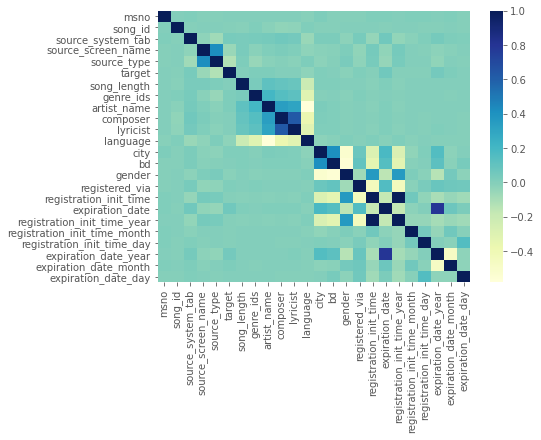

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.show()

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist', 'gender'], 1)

In [13]:
# Model with the best estimator
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

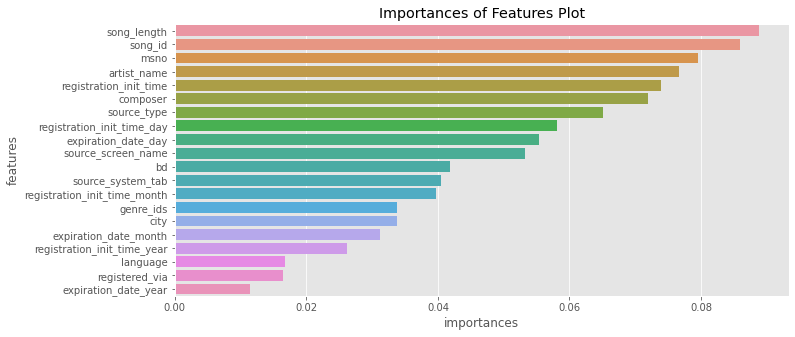

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_day',
       'expiration_date_day'],
      dtype='object')

In [18]:
# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [19]:
# Create model
kf = KFold(n_splits = 3)
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(train_data, train_labels)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [20]:
# Predicting
predict_labels = model.predict(test_data)

In [21]:
print(sklearn.metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64    109761
           1       0.65      0.69      0.67    111562

    accuracy                           0.66    221323
   macro avg       0.66      0.66      0.66    221323
weighted avg       0.66      0.66      0.66    221323

